### Проверка гипотез для интернет-магазина.

Вместе с отделом маркетинга были подготовлены список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Описание данных
- Данные для первой части  
Файл /datasets/hypothesis.csv. 
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
 
 
- Данные для второй части  
Файл /datasets/orders.csv 
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.
 
 Файл /datasets/visitors.csv
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Общая информация
Загрузим данные и подготовим их к анализу

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import math
from scipy import stats as st 
import seaborn as sns

import datetime as dt
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
# hypothesis = pd.read_csv('/datasets/hypothesis.csv')
# orders = pd.read_csv('/datasets/orders.csv')
# visitors = pd.read_csv('/datasets/visitors.csv')

hypothesis = pd.read_csv('C:/Users/TOSHIBA/Documents/project_python/AB-test/hypothesis.csv')

orders = pd.read_csv('C:/Users/TOSHIBA/Documents/project_python/AB-test/orders.csv')
visitors = pd.read_csv('C:/Users/TOSHIBA/Documents/project_python/AB-test/visitors.csv')

In [14]:
# функция для вывода информации о датафрейме и 5 первых строк датафрейма
def show_info(df):    
    display(df.head(5))
    display(df.info())

In [15]:
for df in [hypothesis, orders, visitors]:
    show_info(df)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Переведем названия столбцов датафреймa `hypothesis` в нижний регистр

In [16]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Переведем столбцы `date` датафреймов `visitors` и `orders` в формат даты

In [17]:
# orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
# visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

orders['date'] = orders['date'].map(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

### Вывод
Данные загружены. Пропуски в данных не обнаружены. Столбцы `orders['date']` и `visitors['date']` переведены в формат datetime64

### Часть 1. Приоритизация гипотез.
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
Задача

- Применим фреймворк ICE для приоритизации гипотез. 
- Применим фреймворк RICE для приоритизации гипотез. 
- Рассмотрим разницу в приоритизации гипотез при применении RICE вместо ICE. 

In [18]:
# Чтобы можно было прочитать полностью гипотезы, установим длину ячейки для вывода равной 110
pd.options.display.max_colwidth = 110

Фреймворк ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») для приоритизации гипотез

In [19]:
hypothesis['ice'] =  hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values('ice',  ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Применив фреймворк ICE, на первых местах по значимости оказались гипотезы о скидке в день рождения, о двух новых каналах привлечения траффика и гипотеза о форме подписке, чтобы собрать базу клиентов для email-рассылок. Все они имеют высокое значение impact, т.е. большое влияние на пользователей, а также confidence.

In [20]:

hypothesis['rice'] = (
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'])
hypothesis.sort_values('rice',  ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


#### Посмотрим, как меняется приоритизация гипотез, при применении фреймворков RICE и ICE

Гипотеза |Приоритет RICE|Приоритет ICE
---|---|---
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок |1|3
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа|2|5
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей| 3|2 
Запустить акцию, дающую скидку на товар в день рождения| 5|1 

### Вывод
Применив фреймворк RICE, мы добавили к рассмотрению параметр охват пользователей. На первое место выходит гипотеза о добавлении формы и сборе базы для  email-рассылок, т.к у нее самый большой охват аудитории, reach =10, на втором месте добавить блоки рекомендаций на сайт, также большой охват и низкая стоимость воплощения (efforts=3). На третьем месте, гипотеза о том, чтобы добавить два новых канала привлечения траффика, reach =3, но остальные параметры высокие, для фреймворка ICE эта гипотеза была на втором месте. Гипотеза о скидки на день рождение опустилась с первого места на пятое, ведь охват пользователей очень мал, день рождения лишь раз в году.


### Часть 2. Анализ A/B-теста
Был проведен A/B-тест и получены результаты, они описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.



Соберём кумулятивные данные по дням  о заказах и посетителях, но сначала найдем аномалии из данных.

### Аномалии в данных

Подсчитаем количество заказов по пользователям

In [21]:
# Сгруппируем таблицу `orders` по пользователям,
# и посчитаем количество совершенных каждым пользователем транзакций
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId' : 'count'})

ordersByUsers.sort_values(by='transactionId',ascending=False).head(5)

,visitorId,transactionId
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Построим точечный график количества заказов по пользователям

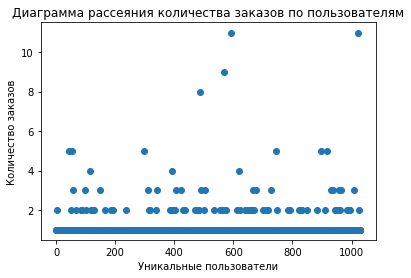

In [22]:
# построим диаграмму рассеяния,
# по оси х зададим значения от 0 до длины массива с уникальными пользователями
# по оси у количество совершенных каждым пользователем транзакций

plt.title('Диаграмма рассеяния количества заказов по пользователям')
plt.xlabel('Уникальные пользователи')
plt.ylabel('Количество заказов')
x_values = pd.Series(range(0,len(ordersByUsers['visitorId'])))
plt.scatter(x_values, ordersByUsers['transactionId']);


Большинство пользователей совершает 1-4 заказа, количество пользователей, совершивших более 4 заказов значительно меньше

Посчитаем 90, 95, 99 перцентили количества заказов на одного пользователя:

In [23]:
np.percentile(ordersByUsers['transactionId'], [90, 95, 99])

array([1., 2., 4.])

99% пользователей совершают от 1 до 4 заказов за выбранный период, оставим в таблице только пользователей, оформивших до 4 заказов, что соответствует 99 перцентилю.

In [24]:
percentile_99_by_orders = np.percentile(ordersByUsers['transactionId'], 99)


#### Построим точечный график стоимостей заказов.

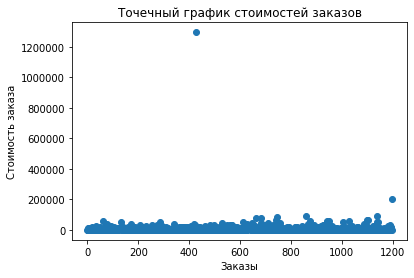

In [25]:
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа')
x_values = pd.Series(range(0,len(orders['revenue'])))
# plt.ylim(0,100000)
plt.scatter(x_values, orders['revenue'])

Один заказ более чем на миллион рублей, он способен значительно исказить результаты теста. Остальные заказы не превышают 100-200 тысяч рублей. Построим тот же график, но зададим лимит по оси "у" в 150 тысяч рублей.

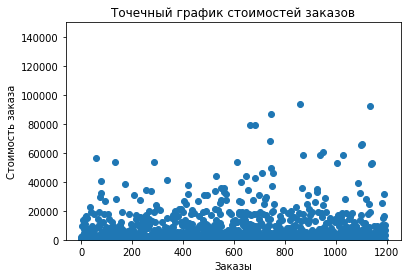

In [26]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.ylim(0,150000)
plt.scatter(x_values, orders['revenue'])

plt.title('Точечный график стоимостей заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа');

Большинство заказов на сумму менее 20 000 рублей, единственный заказ на миллион может исказить результаты теста. 

Посчитаем 95-й и 99-й перцентили стоимости заказов

In [27]:
np.percentile(orders['revenue'],[95,99])

array([28000. , 58233.2])

Выберем за нижнюю границу для определения аномальных заказов сумму соответствующую 99 перцентилю - 58 тысяч рублей

In [28]:
percentile_99_by_revenue = np.percentile(orders['revenue'], 99)

 Составим список аномальных покупателей с заказами более 4, что соответствует 99 перцентилю

In [29]:
# Составим список аномальных покупателей с заказами более 4, что соответствует 99 перцентилю
anomal_visitor =  ordersByUsers[ordersByUsers['transactionId'] > percentile_99_by_orders]['visitorId']
anomal_visitor

44       199603092
55       237748145
299     1230306981
487     2038680547
569     2378935119
591     2458001652
744     3062433592
897     3717692402
917     3803269165
1023    4256040402
Name: visitorId, dtype: int64

Получим таблицу `orders_without_anomaly`, где сумма заказов не превышает сумму соответствующую 99 перцентилю, и нет покупателей из списка `anomal_visitor`, где собраны покупатели с заказами более 4

In [30]:
orders_without_anomaly =(
    orders[np.logical_and(orders['revenue'] < percentile_99_by_revenue,
            np.logical_not(orders['visitorId'].isin(anomal_visitor)))]
                         )
orders_without_anomaly

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


### Вывод
Мы получили таблицу `orders_without_anomaly`, в которой нет аномальных заказов. Аномальными признаны заказы, выручка которых превышает 58 тысяч рублей, что соответствует 99 перцентилю, аномальными пользователями - покупатели с заказами более 4, что также соответствует 99 перцентилю Такие покупатели занесены в список `anomal_visitor`. 

### Кумулятивные данные по дням  о заказах и посетителях

Создадим массив уникальных пар значений дат и групп теста. Сгруппируем `orders` по `'date','group'` и оставим в таблице только уникальные пары, удалив дубликаты.

In [31]:
datesGroups = orders[['date','group']].drop_duplicates().sort_values('date')
datesGroups.head()

,date,group
55,2019-08-01,A
66,2019-08-01,B
175,2019-08-02,A
173,2019-08-02,B
291,2019-08-03,A


Для каждой уникальной даты `x['date'] из datesGroups`  мы берем все строчки из таблицы `orders`, которые меньше этой даты,  и группу теста `orders['group']`,  и получаем данные:
- `date`' - максимальная дата, то есть последний день наблюдений, 
- `'group'` - группа А или В
- `'transactionId'` - количество заказов, за дни наблюдений
- `'visitorId'` - количество уникальных покупателей, попавших в дни наблюдений
- `'revenue'` - выручка за все дни наблюдений


In [32]:
orders_aggregated =(
    datesGroups.apply(
        lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                        orders['group'] == x['group'])]
        .agg({'date' : 'max', 
              'group' : 'max', 
              'transactionId' : pd.Series.nunique,
              'visitorId' : pd.Series.nunique, 
              'revenue' : 'sum'}), axis=1)
    .sort_values(by=['group','date'])
)
orders_aggregated


,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
175,2019-08-02,A,44,38,242401
291,2019-08-03,A,68,62,354874
499,2019-08-04,A,84,77,425699
698,2019-08-05,A,109,100,549917
...,...,...,...,...,...
715,2019-08-27,B,548,504,5232260
305,2019-08-28,B,576,526,5328268
496,2019-08-29,B,596,544,5559398
690,2019-08-30,B,620,567,5774631


Чтобы посчитать кумулятивную сумму посетителей по дням, сгруппируем по группе теста и применим функцию cumsum, 

In [33]:
visitors['cum_visitors'] = (
    visitors.groupby(['group']).agg(cum_visitors = ('visitors','cumsum'))['cum_visitors']
)

visitors

,date,group,visitors,cum_visitors
0,2019-08-01,A,719,719
1,2019-08-02,A,619,1338
2,2019-08-03,A,507,1845
3,2019-08-04,A,717,2562
4,2019-08-05,A,756,3318
...,...,...,...,...
57,2019-08-27,B,720,16523
58,2019-08-28,B,654,17177
59,2019-08-29,B,531,17708
60,2019-08-30,B,490,18198


Сведем все данные в одну таблицу

In [34]:
cumulative_data=[]
cumulative_data = orders_aggregated.merge(visitors , left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data = cumulative_data.rename(
    columns={
        "transactionId": "cum_orders",
        "visitorId": "cum_unique_users",
        "revenue" :"cum_revenue"        
})
cumulative_data

,date,group,cum_orders,cum_unique_users,cum_revenue,visitors,cum_visitors
0,2019-08-01,A,24,20,148579,719,719
1,2019-08-02,A,44,38,242401,619,1338
2,2019-08-03,A,68,62,354874,507,1845
3,2019-08-04,A,84,77,425699,717,2562
4,2019-08-05,A,109,100,549917,756,3318
...,...,...,...,...,...,...,...
57,2019-08-27,B,548,504,5232260,720,16523
58,2019-08-28,B,576,526,5328268,654,17177
59,2019-08-29,B,596,544,5559398,531,17708
60,2019-08-30,B,620,567,5774631,490,18198


Разделим данные на группы А и В:


In [35]:
cumulative_a = cumulative_data[cumulative_data['group']=='A']
cumulative_b = cumulative_data[cumulative_data['group']=='B']


### График кумулятивной выручки по группам. 


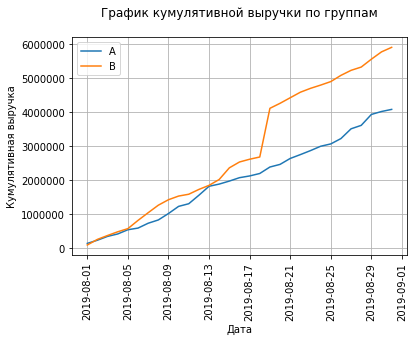

In [36]:

plt.title('График кумулятивной выручки по группам'+ '\n')
plt.grid()
plt.xticks( rotation='vertical')
sns.lineplot(data = cumulative_a, x = 'date', y = 'cum_revenue', label='A')
sns.lineplot(data = cumulative_b, x = 'date', y = 'cum_revenue', label='B');
plt.ylabel('Кумулятивная выручка')
plt.xlabel('Дата');

Выручка обеих групп равномерно растет. Сначала выручка почти одинакова, однако выручка группы В в одной точке резко выросла, и к концу теста выручка группы В значительно опережает группу А. В выборке есть очень дорогие заказы, необходимо посмотреть на график выручки без аномально больших заказов.

Построим график кумулятивной выручки для очищенных данных, для этого повторим все действия на датафрейме `orders_without_anomaly`


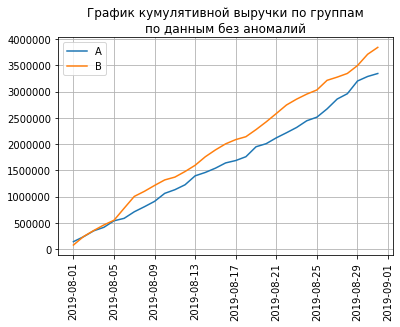

In [37]:
# получим кумулятивное количество заказов и покупателей на каждую дату
orders_filtred_agg =(
    datesGroups.apply(
        lambda x: orders_without_anomaly[np.logical_and(orders_without_anomaly['date'] <= x['date'], 
                                        orders_without_anomaly['group'] == x['group'])]
        .agg({'date' : 'max', 
              'group' : 'max', 
              'transactionId' : pd.Series.nunique,
              'visitorId' : pd.Series.nunique, 
              'revenue' : 'sum'}), axis=1)
    .sort_values(by=['group','date'])
)
orders_filtred_agg

# Сведем все данные в одну таблицу
cumulative_data_filtred = orders_filtred_agg.merge(
    visitors , left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data_filtred = cumulative_data_filtred.rename(
    columns={
        "transactionId": "cum_orders",
        "visitorId": "cum_unique_users",
        "revenue" :"cum_revenue"        
})
cumulative_data_filtred

# Разделим данные на группы А и В:
cumulative_filtred_a = cumulative_data_filtred[cumulative_data_filtred['group']=='A']
cumulative_filtred_b = cumulative_data_filtred[cumulative_data_filtred['group']=='B']

# График кумулятивной выручки по группам. 

plt.title('График кумулятивной выручки по группам'+ '\n' + 'по данным без аномалий')
plt.plot(cumulative_filtred_a['date'], cumulative_filtred_a['cum_revenue'], label='A')
plt.plot(cumulative_filtred_b['date'], cumulative_filtred_b['cum_revenue'], label='B');
plt.legend()
plt.grid()
plt.xticks( rotation='vertical');

На графике без аномально больших заказов теперь нет скачков. Группа В явно лидирует по суммарной выручке.

### Построим график кумулятивного среднего чека по группам

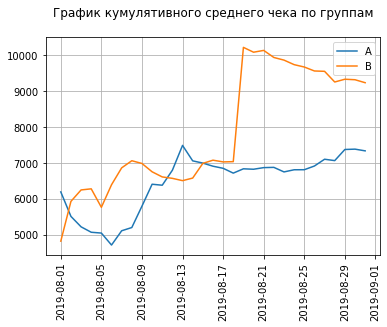

In [38]:
plt.title('График кумулятивного среднего чека по группам'+ '\n')

plt.plot(cumulative_a['date'], (cumulative_a['cum_revenue'] / cumulative_a['cum_orders']), label='A')
plt.plot(cumulative_b['date'], cumulative_b['cum_revenue'] / cumulative_b['cum_orders'], label='B');
plt.legend()
plt.grid()
plt.xticks( rotation='vertical');

Графики обеих групп очень не равномерны, есть пики и провалы. Средний чек зависит от суммарной выручки и количества заказов, очевидно, в обоих метриках есть аномалии. Несмотря на то, что средний чек много выше у группы В, к концу наблюдений график среднего чека В падает, а у группы А к концу наблюдений график растет, поэтому выводы можно будет сделать лишь очистив данные от аномалий

### Построим график кумулятивного среднего чека по группам по очищенным данным

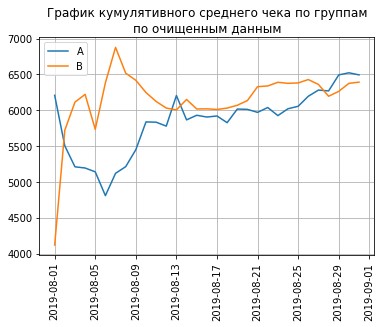

In [39]:
plt.title('График кумулятивного среднего чека по группам'+ '\n' + 'по очищенным данным')

plt.plot(cumulative_filtred_a['date'], 
         (cumulative_filtred_a['cum_revenue'] / cumulative_filtred_a['cum_orders']), label='A')
plt.plot(cumulative_filtred_b['date'],
         cumulative_filtred_b['cum_revenue'] / cumulative_filtred_b['cum_orders'], label='B');
plt.legend()
plt.grid()
plt.xticks( rotation='vertical');

В первую неделю наблюдений средний чек группы В резко вырос, но потом стал уменьшатся и к концу месяца налюдений он стал колебаться гораздо меньше, но тенденция еще не ясна, будет ли он далее расти или падать. Средний чек группы А в первую неделю наблюдений резко упал, но потом начал увеличиваться, и к концу наблюдений установился выше чем, у группы В.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

Соединим таблицы по группам А и В

In [40]:
merged_cumulative = cumulative_a.merge(
    cumulative_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# добавим столбец относительного изменения кумулятивного среднего чека группы B к группе A
merged_cumulative ['revenue_mean_b_a'] = (
    (merged_cumulative['cum_revenueB']/merged_cumulative['cum_ordersB'])/
    (merged_cumulative['cum_revenueA']/merged_cumulative['cum_ordersA']) - 1
)
merged_cumulative.head()

,date,groupA,cum_ordersA,cum_unique_usersA,cum_revenueA,visitorsA,cum_visitorsA,groupB,cum_ordersB,cum_unique_usersB,cum_revenueB,visitorsB,cum_visitorsB,revenue_mean_b_a
0,2019-08-01,A,24,20,148579,719,719,B,21,20,101217,713,713,-0.22
1,2019-08-02,A,44,38,242401,619,1338,B,45,43,266748,581,1294,0.08
2,2019-08-03,A,68,62,354874,507,1845,B,61,59,380996,509,1803,0.20
3,2019-08-04,A,84,77,425699,717,2562,B,78,75,489567,770,2573,0.24
4,2019-08-05,A,109,100,549917,756,3318,B,101,98,581995,707,3280,0.14


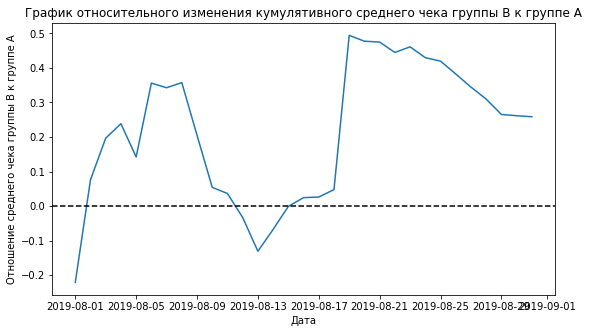

In [41]:
plt.figure(figsize=(9,5))
sns.lineplot(data = merged_cumulative, x = 'date', y = 'revenue_mean_b_a')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека группы B к группе A')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');


График изменения среднего чека группы В к А в нескольких точках резко взлетает и падает, значит крупные заказы есть, как в группе А, так и в группе В.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A по очищенным данным 

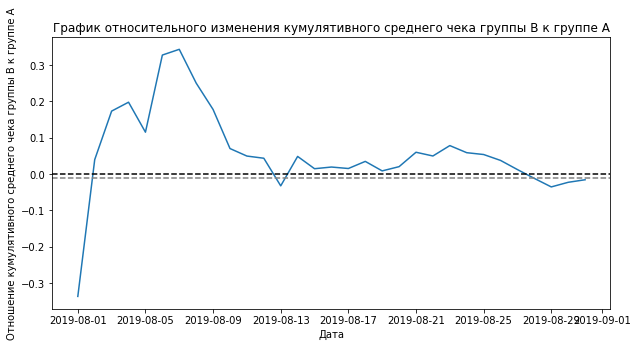

In [42]:
merged_cum_filtred = cumulative_filtred_a.merge(
    cumulative_filtred_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# добавим столбец относительного изменения кумулятивного среднего чека группы B к группе A
merged_cum_filtred ['revenue_mean_b_a'] = (
    (merged_cum_filtred['cum_revenueB']/merged_cum_filtred['cum_ordersB'])/
    (merged_cum_filtred['cum_revenueA']/merged_cum_filtred['cum_ordersA']) - 1
)


plt.figure(figsize=(10,5))
sns.lineplot(data = merged_cum_filtred, x = 'date', y = 'revenue_mean_b_a')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= -0.01, color='gray', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего чека группы B к группе A')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');


Различия среднего чека групп А и В колеблется около нуля. К концу наблюдений средний чек группы В всего на 1% хуже, чем угруппы А. 

### Построим график кумулятивной конверсии по группам.

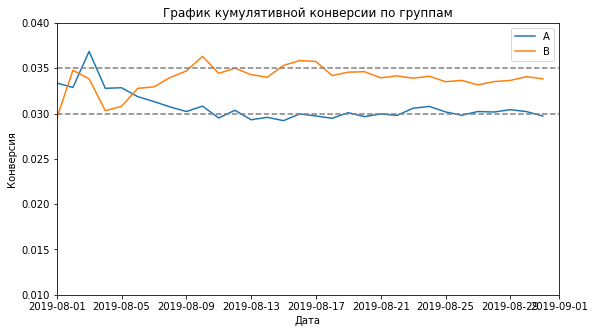

In [43]:
merged_cumulative['conversionA'] = merged_cumulative['cum_ordersA']/merged_cumulative['cum_visitorsA']
merged_cumulative['conversionB'] = merged_cumulative['cum_ordersB']/merged_cumulative['cum_visitorsB']


plt.figure(figsize=(9,5))
sns.lineplot(data = merged_cumulative, x = 'date', y = 'conversionA', label='A')
sns.lineplot(data = merged_cumulative, x = 'date', y = 'conversionB', label='В')
plt.axhline(y=0.035, color='gray', linestyle='--')
plt.axhline(y=0.03, color='gray', linestyle='--')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('График кумулятивной конверсии по группам');
# задаем масштаб осей
# plt.axis(['2019-08-01', '2019-09-01', 0, 0.04]);
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), 0.01, 0.04]);


In [56]:
merged_cumulative.head(10)

,date,groupA,cum_ordersA,cum_unique_usersA,cum_revenueA,visitorsA,cum_visitorsA,groupB,cum_ordersB,cum_unique_usersB,cum_revenueB,visitorsB,cum_visitorsB,revenue_mean_b_a,conversionA,conversionB
0,2019-08-01,A,24,20,148579,719,719,B,21,20,101217,713,713,-0.22,0.03,0.03
1,2019-08-02,A,44,38,242401,619,1338,B,45,43,266748,581,1294,0.08,0.03,0.03
2,2019-08-03,A,68,62,354874,507,1845,B,61,59,380996,509,1803,0.20,0.04,0.03
3,2019-08-04,A,84,77,425699,717,2562,B,78,75,489567,770,2573,0.24,0.03,0.03
4,2019-08-05,A,109,100,549917,756,3318,B,101,98,581995,707,3280,0.14,0.03,0.03
5,2019-08-06,A,127,114,598401,667,3985,B,129,123,824337,655,3935,0.36,0.03,0.03
6,2019-08-07,A,145,131,740818,644,4629,B,153,146,1049671,709,4644,0.34,0.03,0.03
7,2019-08-08,A,161,146,837097,610,5239,B,180,171,1270589,654,5298,0.36,0.03,0.03
8,2019-08-09,A,177,159,1025603,617,5856,B,205,193,1431401,610,5908,0.21,0.03,0.03
9,2019-08-10,A,193,175,1236098,406,6262,B,228,215,1539203,369,6277,0.05,0.03,0.04


В группе В конверсия зафиксировалась на уровне 0.035, в группе А конверсия зафиксировалась на уровне 0.03

#### Построим график кумулятивной конверсии по группам по очищенным данным

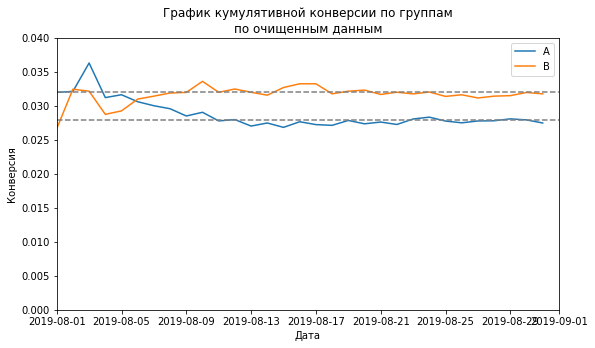

In [44]:
merged_cum_filtred['conversionA'] = merged_cum_filtred['cum_ordersA']/merged_cum_filtred['cum_visitorsA']
merged_cum_filtred['conversionB'] = merged_cum_filtred['cum_ordersB']/merged_cum_filtred['cum_visitorsB']


plt.figure(figsize=(9,5))
sns.lineplot(data = merged_cum_filtred, x = 'date', y = 'conversionA', label='A')
sns.lineplot(data = merged_cum_filtred, x = 'date', y = 'conversionB', label='В')
plt.axhline(y=0.032, color='gray', linestyle='--')
plt.axhline(y=0.028, color='gray', linestyle='--')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('График кумулятивной конверсии по группам'+'\n' + 'по очищенным данным');
# задаем масштаб осей
# plt.axis(["2019-08-01", '2019-09-01', 0, 0.04]);
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), 0, 0.04]);

В группе В конверсия зафиксировалась на уровне 0.032, в группе А конверсия зафиксировалась на уровне 0.028. Конверсия группы В на 14% выше группы А.

### Построим график относительного различия кумулятивных конверсий:

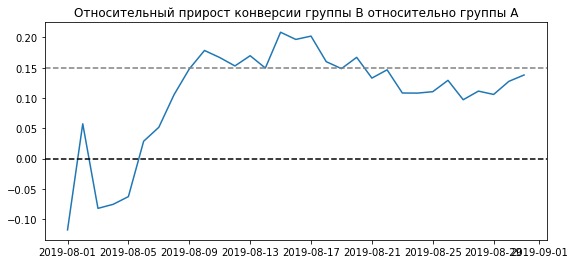

In [45]:
plt.figure(figsize=(9,4))
plt.plot(
    merged_cumulative['date'], merged_cumulative['conversionB']/merged_cumulative['conversionA']-1)
    
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='gray', linestyle='--')
plt.title('Относительный прирост конверсии группы B относительно группы A');



Конверсия группы В выше конверсии группы А.

#### Построим график относительного различия кумулятивных конверсий по очищенным данным

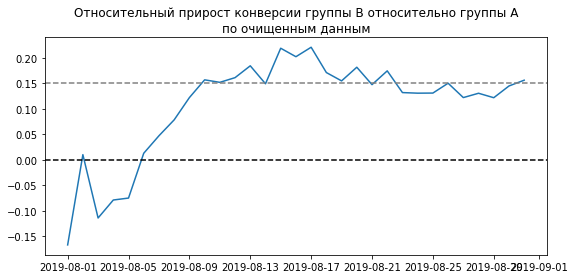

In [46]:
plt.figure(figsize=(9,4))
plt.plot(
    merged_cum_filtred['date'], merged_cum_filtred['conversionB']/merged_cum_filtred['conversionA']-1)
    
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='gray', linestyle='--')
plt.title('Относительный прирост конверсии группы B относительно группы A' +'\n'+'по очищенным данным');



График различия конверсии между группами , как для "сырых", так и для очищенных данных сообщает, что результаты группы B лучше группы A 

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Изменения конверсия и среднего чека не подходит под график нормального распределения исходных данных. Для определения статистической значимости различий в конверсии рассмотрим тест, основанный на структурном подходе, или непараметрический. Метод, который будем применять для A/B-тестирования, называется `st.mannwhitneyu()` (от англ. «U-критерий Манна-Уитни»).

Получим 2 таблицы по группам А и В с числом совершенных заказов для каждого покупателя по группам

In [47]:
orders_by_users_a = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg(
    {'transactionId' : 'nunique'})
orders_by_users_a.columns = ['user_id', 'orders_count']

orders_by_users_b = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg(
    {'transactionId' : 'nunique'})
orders_by_users_b.columns = ['user_id', 'orders_count']
# orders_by_users_b

 Чтобы подготовить выборки к проверке критерием Манна-Уитни, нам нужны две последовательности со всеми пользователями из теста и количество заказов, совершенного каждым пользователем. Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

Переменная sampleA должна состоять из двух частей:  

- Список с количеством заказов для каждого из пользователей: `orders_by_users_a['orders_count']`.
- Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах: `merged_cumulative['visitorsA'].sum() - len(orders_by_users_a['orders_count'])`.  

Соединим списки с помощью функции pd.concat(), axis=0 

In [48]:
sampleA = pd.concat(
    [orders_by_users_a['orders_count'],
     pd.Series(0,index=np.arange
               (merged_cumulative['visitorsA'].sum() - len(orders_by_users_a['orders_count'])),
    name='orders')],axis=0)
sampleA

sampleB = pd.concat(
    [orders_by_users_b['orders_count'],
     pd.Series(0,index=np.arange
               (merged_cumulative['visitorsB'].sum() - len(orders_by_users_b['orders_count'])),
    name='orders')],axis=0)
sampleB

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Length: 18916, dtype: int64

Число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). Относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1, то есть `sampleB.mean()/sampleA.mean() - 1`

#### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным
Нулевая гипотеза: статистически значимых различий в конверсии между группами нет

In [49]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(sampleA, sampleB)
print("p-value = {0:.3f}".format(results[1]))


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")



display('Относительный прирост конверсии группы B: {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1))

p-value = 0.008
Отвергаем нулевую гипотезу: разница статистически значима


'Относительный прирост конверсии группы B: 0.138'

### Вывод
p-value меньше 0.05, значит нулевую гипотезу отвергаем, т.о. статистически значимые различия в конверсии есть, причем в группе В конверсия лучше, чем вгруппе А на 13,8%

### Статистическая значимость различий в конверсии между группами по  данным без аномалий

Получим 2 таблицы по группам А и В с числом совершенных заказов для каждого покупателя по группам по очищенным данным из `orders_without_anomaly` 

In [50]:
orders_by_users_a_filtred = orders_without_anomaly[orders_without_anomaly['group']=='A']\
                  .groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
orders_by_users_a_filtred.columns = ['user_id', 'orders_count']

orders_by_users_b_filtred = orders_without_anomaly[orders_without_anomaly['group']=='B']\
                    .groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
orders_by_users_b_filtred.columns = ['user_id', 'orders_count']
# orders_by_users_b_filtred


sampleA_filtred = pd.concat(
    [orders_by_users_a_filtred['orders_count'],
     pd.Series(0,index=np.arange
               (merged_cumulative['visitorsA'].sum() - len(orders_by_users_a['orders_count'])),
    name='orders')],axis=0)


sampleB_filtred = pd.concat(
    [orders_by_users_b_filtred['orders_count'],
     pd.Series(0,index=np.arange
               (merged_cumulative['visitorsB'].sum() - len(orders_by_users_b['orders_count'])),
    name='orders')],axis=0)
# sampleB_filtred

Нулевая гипотеза: статистически значимых различий в конверсии между группами нет

In [51]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(sampleA_filtred, sampleB_filtred)
print("p-value = {0:.3f}".format(results[1]))


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")


display('Относительный прирост конверсии группы B: {0:.3f}'.format(
                                     sampleB_filtred.mean()/sampleA_filtred.mean()-1))

p-value = 0.006
Отвергаем нулевую гипотезу: разница статистически значима


'Относительный прирост конверсии группы B: 0.156'

### Вывод
Отвергаем нулевую гипотезу, p-value меньше 0.05, т.е. статистически значимые различия в конверсии есть. Причем по очищенным данным относительный прирост конверсии группы B стал даже выше. Теперь конверсия лучше, чем в группе А на 15,6%

### Статистическая значимость различий в  среднем чеке заказа  между группами  по «сырым» данным

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов.

Нулевая гипотеза: статистически значимых различий в среднем чеке между группами нет

In [52]:
orders[orders['group']=='A']['revenue']

2         400
7        1044
8       13710
10       4008
12       7370
        ...  
1187      750
1188      112
1193     3190
1194    10550
1195      100
Name: revenue, Length: 557, dtype: int64

In [53]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print("p-value = {0:.3f}".format(results[1]))


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")



display('Относительный прирост среднего чека группы B: {0:.3f}'.format(
       orders[orders['group']=='B']['revenue'].mean()/
       orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.365
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


'Относительный прирост среднего чека группы B: 0.259'

В выборке по "сырым данным" нет причин отвергать нулевую гипотезу. Нельзя утверждать, что в среднем чеке есть различия. Однако, средний чек группы B значительно выше среднего чека группы A, на 26%.

### Статистическая значимость различий в среднем чеке заказа между группами по  данным без аномалий

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов из датафрейма `orders_without_anomaly`

Нулевая гипотеза: статистически значимых различий в среднем чеке между группами нет

In [54]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(
    orders_without_anomaly[orders_without_anomaly['group']=='A']['revenue'],
    orders_without_anomaly[orders_without_anomaly['group']=='B']['revenue'])
print("p-value = {0:.3f}".format(results[1]))


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")



display('Относительный прирост среднего чека группы B: {0:.3f}'.format(
       orders_without_anomaly[orders_without_anomaly['group']=='B']['revenue'].mean()/
       orders_without_anomaly[orders_without_anomaly['group']=='A']['revenue'].mean()-1))

p-value = 0.491
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


'Относительный прирост среднего чека группы B: -0.016'

### Вывод
Не получилось отвергнуть нулевую гипотезу. Нельзя сделать вывод о различии средних чеков разных групп. Убрав из данных очень большие заказы, средний чек группы В, стал меньше среднего чека А на 1.6%, однако это могло получится случайно.

### Общий вывод
1. Из графиков по "очищенным" данным:

Группа В  лидирует по суммарной выручке.   
По среднему чеку в группе В еще не установилась тенденция, будет ли он далее расти или падать. К концу наблюдений средний чек установился ниже, чем угруппы А.  
По графику относительного изменения кумулятивного среднего чека группы B к группе A, различия среднего чека групп А и В колеблется около нуля.  
В группе В конверсия зафиксировалась на уровне 0.032, в группе А конверсия зафиксировалась на уровне 0.028. 
Конверсия группы В на 15% выше группы А.

2. Статистическая значимость: 

По "сырым" данным  - статистически значимые различия в конверсии есть, причем в группе В конверсия лучше, чем в группе А на 13,8%  
По "очищенным данным" - статистически значимые различия в конверсии есть, в группе В конверсия лучше, чем в группе А на 15,6%   

По "сырым" данным - нельзя утверждать, что в среднем чеке разных групп есть различия, средний чек группы B значительно выше среднего чека группы A, на 26%.
По "очищенным данным" - нельзя утверждать, что в среднем чеке разных групп есть различия, средний чек группы B ниже среднего чека группы A, на 1.6%.

3. Рекомендации по результатам теста

Исходя из обнаруженных фактов, я рекомендую остановить  тест и признать его успешным. Разница в среднем чеке статистически незначима, а конверсия группы В выше конверсии группы А на 15%, и есть статистически значимые различия в конверсии. Это значит, что суммарная выручка в группе В будет расти.